The purpose of this notebook is to manually generate psv sim files for desired cases.

In [1]:
!which python

/Users/josephpicca/opt/anaconda3/envs/impacts-prod/bin/python


In [2]:
import datetime
import gzip
import pathlib
from os import environ as E

#import geojson
import numpy as np
import pyproj
from scipy import stats

import dclasses as dc
import pygrib as pg

In [3]:
import io
import pandas as pd

In [4]:
# This is purely for plotting purposes

import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import pygridder as pgrid

import warnings
warnings.filterwarnings('ignore')

In [5]:
### Parse CLI Arguments ###
ndfd_file = pathlib.Path('../data/output/examples/20110427/ndfd/torn_day1_grib2_1630_20110427162927')

pp_file = pathlib.Path('./test.npz')
ndfd_area = 25
nsims = 10000
tornado_direction_distribution = stats.norm(50, 15)
coolseason = [1, 2, 3, 4, 11, 12]

In [6]:
impacts_data_root = pathlib.Path('../scripts/pas-input-data/')

In [7]:
outdir = pathlib.Path('../data/',"output").resolve()
outdir.mkdir(exist_ok=True)

In [8]:
# Read grib file
def read_ndfd_grib_file(grbfile):
    """ Read an SPC Outlook NDFD Grib2 File """
    with pg.open(grbfile.as_posix()) as GRB:
        try:
            vals = GRB[1].values.filled(-1)
        except AttributeError:
            vals = GRB[1].values
    return vals

In [9]:
date_in_name = ndfd_file.name.split("_")[-1]
dt = datetime.datetime.strptime(date_in_name, "%Y%m%d%H%M%S")
outfile = outdir.joinpath(f"{dt.strftime('%Y%m%d%H%M%S')}_directional.psv.gz")

In [10]:
torn = read_ndfd_grib_file(ndfd_file)
# fcsts = np.load('test.npz')
# Multiply 100 to convert from decimal to percent
# torn = fcsts['all_fcst']*100

In [11]:
np.unique(torn)

array([-1.,  0.,  2.,  5., 10., 15., 30., 45.])

<hr>

#### Editing probabilities

In [44]:
torn = np.where(np.isin(igrids.wfo, ['JAN', 'MOB', 'BMX', 'TLH','FFC','HUN','MEG']), 30.0, torn)

In [46]:
sigtorn = np.where(np.isin(igrids.wfo, ['JAN', 'MOB', 'BMX', 'TLH','FFC','HUN','MEG']), 10, sigtorn)

<hr>

#### Finer continuous probs

In [19]:
from skimage import measure
from scipy import interpolate as I

In [121]:
def interpol(image):
    valid_mask = image > 0
    coords = np.array(np.nonzero(valid_mask)).T
    values = image[valid_mask]
    INTERP = I.LinearNDInterpolator(coords, values, fill_value=0)
    new_image = INTERP(list(np.ndindex(image.shape))).reshape(image.shape)
    return new_image

In [160]:
vals = [1, 2, 5, 10, 15, 30, 45, 60]
continuous = np.zeros_like(torn)
contours = [measure.find_contours(torn, v-1e-10) for v in vals]
for tcontours, val in zip(contours, vals):
    for contour in tcontours:
        x, y = zip(*contour.astype(int))
        continuous[x, y] = val
continuous = interpol(continuous) #.astype(int, copy=False)
rounded = (continuous*2).round()/2
rounded[torn < vals[0]] = 0

In [161]:
np.unique(rounded)

array([ 0. ,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,
        7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. ,
       12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5,
       18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. ,
       23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5,
       29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5, 34. ,
       34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5, 39. , 39.5,
       40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5, 45. ])

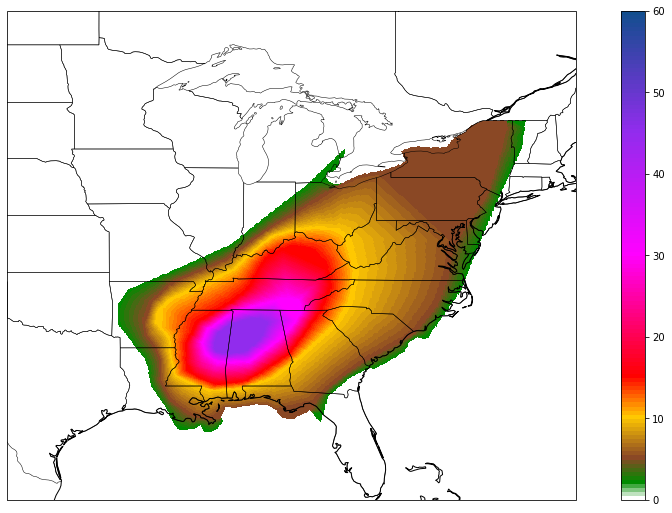

In [169]:
fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100,-70,25,50])
ax.add_feature(cfeature.STATES, linewidth=0.5)
plt.pcolormesh(igrids.lons,igrids.lats,rounded,transform=ccrs.PlateCarree(),cmap=continuous_cmap,vmin=0,vmax=60)
plt.colorbar()

ax.coastlines()

<hr>

In [17]:
continuous_torn = dc.make_continuous(torn)

In [45]:
sigtorn = read_ndfd_grib_file(ndfd_file.with_name(ndfd_file.name.replace("torn", "sigtorn"))).astype(int)

# sigtorn = fcsts['sig_fcst']*100

In [48]:
sigtorn[sigtorn > 0] = 1
if (torn.max() >= 30) and (sigtorn.max() > 0):
    sigtorn[torn >= 15] += 1
sigtorn_1d = sigtorn.ravel()
usesig = True if (dt.month in coolseason) or (sigtorn.max() > 0) else False

In [49]:
### Run Tornado Count Simulation ###
print(f"Running {nsims:,d} Tornado Count Simulations")
tornado_dists = dc.TornadoDistributions()
counts = np.zeros((5, nsims), dtype=int)
counts[0, :] = (tornado_dists.f02.rvs(nsims) * ndfd_area * (torn == 2).sum()).astype(int)
counts[1, :] = (tornado_dists.f05.rvs(nsims) * ndfd_area * (torn == 5).sum()).astype(int)
counts[2, :] = (tornado_dists.f10.rvs(nsims) * ndfd_area * (torn == 10).sum()).astype(int)
counts[3, :] = (tornado_dists.f15.rvs(nsims) * ndfd_area * (torn == 15).sum()).astype(int)
counts[4, :] = (tornado_dists.f30.rvs(nsims) * ndfd_area * (torn >= 30).sum()).astype(int)

Running 10,000 Tornado Count Simulations


In [145]:
### Setup Impact Simulation ###
igrids = dc.ImpactGrids(impacts_data_root)

In [50]:
scounts = counts.sum(axis=1)
inds02 = dc.weighted_choice(prob=2, probs=torn, cprobs=continuous_torn, size=scounts[0])
inds05 = dc.weighted_choice(prob=5, probs=torn, cprobs=continuous_torn, size=scounts[1])
inds10 = dc.weighted_choice(prob=10, probs=torn, cprobs=continuous_torn, size=scounts[2])
inds15 = dc.weighted_choice(prob=15, probs=torn, cprobs=continuous_torn, size=scounts[3])
inds30 = dc.weighted_choice(prob=30, probs=torn, cprobs=continuous_torn, size=scounts[4])
inds = dc.flatten_list([inds02, inds05, inds10, inds15, inds30])

In [51]:
non_sig_inds = sigtorn_1d[inds] == 0
single_sig_inds = sigtorn_1d[inds] == 1
double_sig_inds = sigtorn_1d[inds] == 2

In [52]:
if usesig:
    single_sig_inds += non_sig_inds
    non_sig_inds[:] = False

In [53]:
# Handle Locations
non_sig_loc_inds = inds[non_sig_inds]
single_sig_loc_inds = inds[single_sig_inds]
double_sig_loc_inds = inds[double_sig_inds]

In [54]:
# Handle Ratings
_mags=[0, 1, 2, 3, 4, 5]
non_sig_ratings = np.random.choice(_mags, size=non_sig_inds.sum(),
                                    replace=True, p=tornado_dists.r_nonsig)
single_sig_ratings = np.random.choice(_mags, size=single_sig_inds.sum(),
                                        replace=True, p=tornado_dists.r_singlesig)
double_sig_ratings = np.random.choice(_mags, size=double_sig_inds.sum(),
                                            replace=True, p=tornado_dists.r_doublesig)

In [55]:
# Handle Distances
non_sig_distances = dc.get_distances(non_sig_ratings, tornado_dists)
single_sig_distances = dc.get_distances(single_sig_ratings, tornado_dists)
double_sig_distances = dc.get_distances(double_sig_ratings, tornado_dists)

In [56]:
%%time

#print("Running simulations...")
#print("    Non Sig...")
non_sig = dc.simulate(non_sig_loc_inds, non_sig_distances,
                        non_sig_ratings, tornado_direction_distribution, igrids)
#print("    Single Sig...")
single_sig = dc.simulate(single_sig_loc_inds, single_sig_distances,
                            single_sig_ratings, tornado_direction_distribution, igrids)
#print("    Double Sig...")
double_sig = dc.simulate(double_sig_loc_inds, double_sig_distances,
                            double_sig_ratings, tornado_direction_distribution, igrids)

CPU times: user 2min 5s, sys: 3.97 s, total: 2min 9s
Wall time: 2min 9s


In [57]:
#print("Splitting simulations back out...")
simulated_tornadoes = dc.flatten_list([non_sig, single_sig, double_sig])
np.random.shuffle(simulated_tornadoes)
_sims = np.split(simulated_tornadoes, counts.sum(axis=0).cumsum())[:-1]
realizations = dc.Realizations([dc.SyntheticTornadoRealization(_sim, i+1) for i, _sim in enumerate(_sims)])


### Ensuring we can read in the psv and that the data check out

In [ ]:
df = pd.read_csv(io.StringIO(realizations.as_psv),sep='|')

In [ ]:
df.groupby('sim').sum()['population'].describe(percentiles=[0.1,0.5,0.9])

In [58]:
with gzip.GzipFile(outfile, "w") as OUT:
    OUT.write(realizations.as_psv.encode())

### Making a continuous color curve

In [142]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

In [150]:
import pickle

In [166]:
import seaborn as sns

In [71]:
raw_colors = [(0,139,0),(138,72,37)] #,(255,200,1)]

fmat_colors = [(color[0]/255,color[1]/255,color[2]/255) for color in colors]
#     print(carr/255)

In [64]:
cmap = LinearSegmentedColormap.from_list('test',fmat_colors,N=4)

In [65]:
x = np.arange(0, np.pi, 0.1)
y = np.arange(0, 2 * np.pi, 0.1)
X, Y = np.meshgrid(x,y)
Z = np.cos(X) * np.sin(Y) * 10

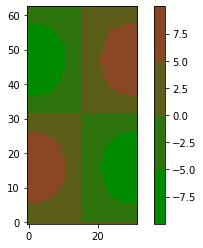

In [68]:
fig, axs = plt.subplots(1,1)

im = axs.imshow(Z, origin='lower',cmap=cmap)
fig.colorbar(im)

In [163]:
raw_colors = [(255,255,255),(0,139,0),(138,72,37),(255,200,1),(255,1,0),(255,1,255),(145,44,237),(14,79,139)]
levels = [0,2,5,10,15,30,45,60]

fmat_colors = [(color[0]/255,color[1]/255,color[2]/255) for color in raw_colors]
#     print(carr/255)

In [83]:
fmat_colors
target_color = fmat_colors[1]
initial_color = fmat_colors[0]

In [133]:
fmat_colors

[(1.0, 1.0, 1.0),
 (0.0, 0.5450980392156862, 0.0),
 (0.5411764705882353, 0.2823529411764706, 0.1450980392156863),
 (1.0, 0.7843137254901961, 0.00392156862745098),
 (1.0, 0.00392156862745098, 0.0),
 (1.0, 0.00392156862745098, 1.0),
 (0.5686274509803921, 0.17254901960784313, 0.9294117647058824),
 (0.054901960784313725, 0.30980392156862746, 0.5450980392156862)]

In [164]:
interpolated_colors = []

for i, (color, level) in enumerate(zip(fmat_colors,levels)):
    
    if i < len(levels)-1:
        
        num_steps = (levels[i+1] - level)*2
        target_color = fmat_colors[i+1]
        initial_color = color
        
#         print(i,color,level,num_steps)
        
        deltas=[(target_color[i] - initial_color[i])/num_steps for i in range(3)]
        
        for j in range(0, num_steps):
            
            interpolated_color=tuple([initial_color[i] + (deltas[i] * j) for i in range(3)])
            interpolated_colors.append(interpolated_color)

In [172]:
pickle.dump(continuous_cmap, open('continuous_tor.cmap', 'wb'))

In [151]:
pickled_cmap = pickle.load(open('../../../gen-assets/continuous_tor.cmap','rb'))

In [166]:
with open('../../../test.txt','r') as f:
    lines = [line.rstrip('\n') for line in f]

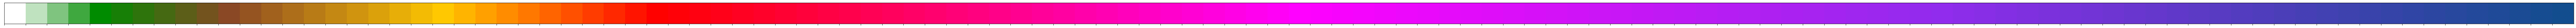

In [167]:
sns.palplot(interpolated_colors)

In [168]:
continuous_cmap = ListedColormap(interpolated_colors)

In [143]:
shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

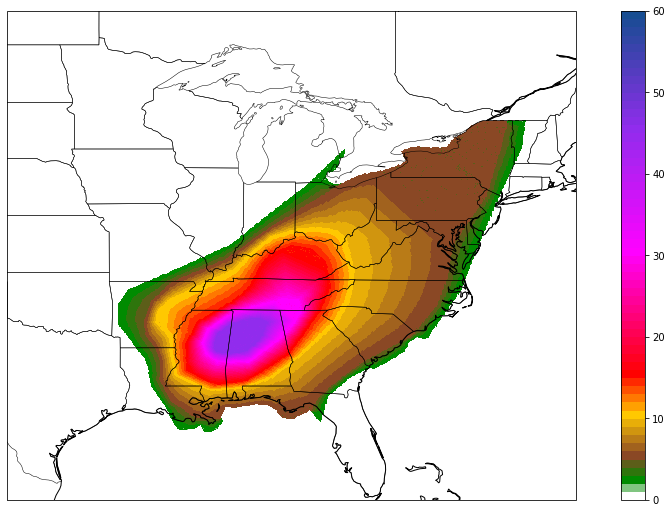

In [179]:
fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100,-70,25,50])
ax.add_feature(cfeature.STATES, linewidth=0.5)
plt.pcolormesh(igrids.lons,igrids.lats,continuous_torn,transform=ccrs.PlateCarree(),cmap=pickled_cmap,vmin=0,vmax=60)
plt.colorbar()

ax.coastlines()

In [1]:
continuous_torn

NameError: name 'continuous_torn' is not defined